In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import h5py
import pickle

# Assuming the model and data loading utilities are available in the specified modules
from Problems.FNOBenchmarks import StrakaBubble, StrakaBubbleDataset, StrakaBubblePlottingDataset
from CNOModule import CNO

# Set device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize dataset
test_dataset = StrakaBubbleDataset(which="test", training_samples=128)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# Path to the saved model
model_path = 'TrainedModels/FNO_straka_bubble_dt_60/model.pkl'
# model_path = 'TrainedModels/CNO_poisson_paper/model.pkl'

# Load the entire model directly
model = torch.load(model_path, map_location=torch.device(device))
model.eval()

/cluster/home/jaking/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:146: UserWarning: 
NVIDIA GeForce RTX 3090 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


FNO2d(
  (act): LeakyReLU(negative_slope=0.01)
  (r): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
  (conv_list): ModuleList(
    (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (4): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (5): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (spectral_list): ModuleList(
    (0): SpectralConv2d()
    (1): SpectralConv2d()
    (2): SpectralConv2d()
    (3): SpectralConv2d()
    (4): SpectralConv2d()
    (5): SpectralConv2d()
  )
  (q): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

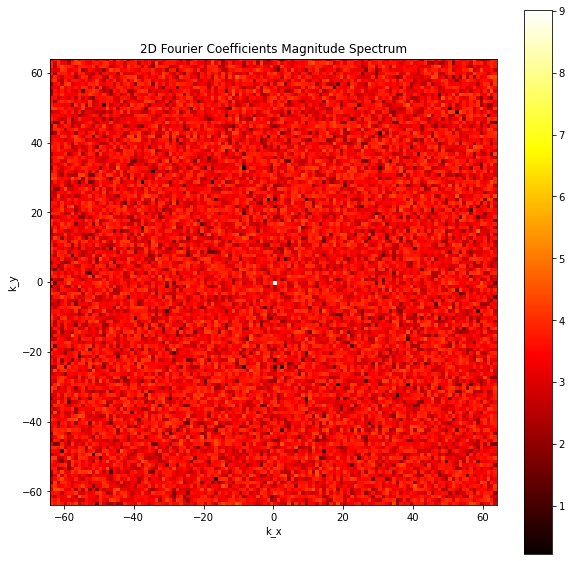

In [15]:
data = np.random.rand(128, 128)
fft_data = np.fft.fft2(data)
fft_data_shifted = np.fft.fftshift(fft_data)
magnitude_spectrum = np.abs(fft_data_shifted)
magnitude_spectrum = np.log(1 + magnitude_spectrum)
plt.figure(figsize=(10, 10))
plt.imshow(magnitude_spectrum, cmap='hot', interpolation='nearest', extent=[-data.shape[1]//2, data.shape[1]//2, -data.shape[0]//2, data.shape[0]//2])
plt.colorbar()
plt.title('2D Fourier Coefficients Magnitude Spectrum')
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.show()

In [ ]:
# Determine the unique grid points
x_unique = np.unique(x)
y_unique = np.unique(y)

# Determine the dimensions of the grid
nx, ny = len(x_unique), len(y_unique)

# Create a meshgrid to arrange the indices
x_indices = np.searchsorted(x_unique, x)
y_indices = np.searchsorted(y_unique, y)

# Create an empty array and populate it
data_grid = np.zeros((nx, ny))
data_grid[x_indices, y_indices] = data

# Compute the 2D Fourier transform and shift zero frequencies to the center
fft_data = np.fft.fftshift(np.fft.fft2(data_grid))

# Compute the magnitude spectrum and use logarithmic scaling for visibility
magnitude_spectrum = np.log(np.abs(fft_data) + 1)

# Plotting
plt.figure(figsize=(10, 10))
plt.imshow(magnitude_spectrum, cmap='hot', interpolation='nearest', extent=[-nx//2, nx//2, -ny//2, ny//2])
plt.colorbar()
plt.title('2D Fourier Coefficients Magnitude Spectrum')
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.show()

In [7]:
import matplotlib.pyplot as plt
import torch
import numpy as np


def plot_samples(data_loader, model, n, device, cmap='coolwarm', vmin=None, vmax=None):
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            for inputs, outputs in batch:
                if i == n:
                    inputs, outputs = inputs.to(device), outputs.to(device)
                    predictions = model(inputs).squeeze(1)  # Ensure predictions match dimensions

                    # Correct data extraction and reshaping based on how your dataloader formats the batch
                    x_coords = inputs[0, :, :, 0].cpu().numpy().flatten()  # Assuming first channel is x-coordinates
                    z_coords = inputs[0, :, :, 1].cpu().numpy().flatten()  # Assuming second channel is y-coordinates
                    temp_values_t_in = inputs[0, :, :, 4].cpu().numpy().flatten()  # Assuming fifth channel is temperature
                    predictions = predictions.cpu().numpy().flatten()
                    temp_values_t_out = outputs[0, :, :, 0].cpu().numpy().flatten()  # Assuming outputs are correctly squeezed

                    fig, axes = plt.subplots(1, 3, figsize=(26, 8), sharex=True, sharey=True)

                    # Input temperature distribution
                    sc1 = axes[0].scatter(x_coords, z_coords, c=temp_values_t_in, cmap=cmap, vmin=vmin, vmax=vmax, s=13)
                    axes[0].set_title("Input Temperatures")
                    axes[0].set_xlabel('X coordinate')
                    axes[0].set_ylabel('Y coordinate')
                    fig.colorbar(sc1, ax=axes[0])

                    # Prediction temperature distribution
                    sc2 = axes[1].scatter(x_coords, z_coords, c=predictions, cmap=cmap, vmin=vmin, vmax=vmax, s=13)
                    axes[1].set_title("Predicted Temperatures")
                    axes[1].set_xlabel('X coordinate')
                    axes[1].set_ylabel('Y coordinate')
                    fig.colorbar(sc2, ax=axes[1])

                    # Output temperature distribution
                    sc3 = axes[2].scatter(x_coords, z_coords, c=temp_values_t_out, cmap=cmap, vmin=vmin, vmax=vmax, s=13)
                    axes[2].set_title("Ground Truth Temperatures")
                    axes[2].set_xlabel('X coordinate')
                    axes[2].set_ylabel('Y coordinate')
                    fig.colorbar(sc3, ax=axes[2])

                    plt.tight_layout()
                    plt.show()
                    break

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_loader = DataLoader(StrakaBubbleDataset(which="training", training_samples=128), batch_size=1, shuffle=False)
plot_samples(test_loader, model, n=10, device=device, cmap='coolwarm', vmin=None, vmax=None)


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.